# Structured Data Lab – Neptun Demo (Jupyter Notebook)

**Cél:** gyakorlati áttekintés strukturált adatokon (Excel/SQL-szerű táblák) – adattisztítás, hiányzó értékek kezelése, pivot táblák, egyszerű riport és adatvizualizáció.  
A példa egy **tanulmányi rendszer** (Neptun) leegyszerűsített modellje: hallgatók, kurzusok, beiratkozások/eredmények.

> A notebook saját, kis demo-adatokat használ, amelyek már a csomagban vannak (`/mnt/data/neptun_demo.xlsx`, `/mnt/data/photos/`). Ha szeretnéd, cseréld ki ezeket a saját fájljaidra!

## 0) Előkészületek – csomagok és beállítások

In [46]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# A grafikonok a notebookban jelenjenek meg
# (No seaborn, no custom styles as requested)
%matplotlib inline

DATA_XLSX = '/mnt/data/neptun_demo.xlsx'
#PHOTOS_DIR = '/mnt/data/photos'

print('Data file:', DATA_XLSX)
#print('Photos dir:', PHOTOS_DIR)


Data file: /mnt/data/neptun_demo.xlsx


1. feladat: Könyvtárak ellenőrzése.
Ellenőrizd, hogy a verziók telepítve vannak-e.

In [47]:
import pandas as pd
import numpy as np
import matplotlib
import PIL

print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("PIL version:", PIL.__version__)

Pandas version: 2.2.2
Numpy version: 1.26.4
Matplotlib version: 3.8.4
PIL version: 10.3.0


In [52]:
!pwd

/cygdrive/c/Users/student/Desktop/adatkezelÅ‘


2. feladat: Állíts be egy rossz fájlnevet! Javítsd ki a helyes útvonalra (/mnt/data/neptun_demo.xlsx), és futtasd újra.

In [48]:
DATA_XLSX = "mnt/data/neptun_demo.xlsx"
import pandas as pd

try:
    df = pd.read_excel(DATA_XLSX)
except FileNotFoundError as e:
    print("Hiba történt:", e)

Hiba történt: [Errno 2] No such file or directory: 'mnt/data/neptun_demo.xlsx'


## 1) Adatok betöltése (Excel – több munkalap)

Fontos!

1. Valós adatok mindig több forrásból jönnek.
* Ezek külön munkalapokban (vagy külön fájlokban, adatbázis-táblákban) találhatók, és később össze kell őket kapcsolni.
2. Adatstruktúra tiszteletben tartása
* Az Excel-fájlban az oszlopok → mezők, a sorok → rekordok.

* Lényeges, hogy betöltéskor ne sérüljön a szerkezet (pl. ne keverje össze a fejlécet az adatokkal, ne olvassa szövegként a dátumokat).

3. Adattípusok helyes felismerése
* Pl. a grade numerikus (float), a enrolled_at dátum (datetime), a name szöveg (string).

* Ha ezeket **nem jól** ismeri fel a betöltés, akkor a későbbi műveletek (számolás, szűrés, pivot) hibát okoznak. Ezért van a parse_dates paraméter is.

4. Alap az ellenőrzéshez. Betöltés után mindig érdemes megnézni a head()-et (első 5 sor) és a dtypes-et (adat-típusok).

In [51]:
students = pd.read_excel(DATA_XLSX, sheet_name='students')
courses = pd.read_excel(DATA_XLSX, sheet_name='courses')
enrollments = pd.read_excel(DATA_XLSX, sheet_name='enrollments', parse_dates=['enrolled_at'])


print('Students:')
display(students.head())
print('Courses:')
display(courses.head())
print('Enrollments:')
display(enrollments.head())

FileNotFoundError: [Errno 2] No such file or directory: 'mnt/data/neptun_demo.xlsx'

## 2) Adattisztítás – whitespace, kis-nagybetűk, hiányzó mezők

**Feladatok:**
1. `name` mező tisztítása (dupla szóközök, trim).  
2. `email` üres értékeinek pótlása (pl. *unknown* domainnel).  
3. `kiss réka` → név formázása címkézett kezdőbetűkkel.  
4. `enrollments` duplikátumainak kiszűrése (azonos `neptun + course_id`).

In [50]:
# 1) Trim és belső whitespace normalizálás
students['name'] = students['name'].str.strip().str.replace(r'\s+', ' ', regex=True)

# 2) Hiányzó e-mailek pótlása
students['email'] = students['email'].replace('', np.nan)
students['email'] = students['email'].fillna(students['neptun'].str.lower() + '@unknown.example.com')

# 3) Név egységesítése – title case (ékezetekre figyel: Python alap title() egyszerűsít, de demo célra elég)
students['name'] = students['name'].str.title()

# 4) Duplikált beiratkozások eltávolítása (azonos NEPTUN + kurzus)
before = len(enrollments)
enrollments = enrollments.sort_values(['neptun','course_id','enrolled_at']).drop_duplicates(subset=['neptun','course_id'], keep='first')
after = len(enrollments)

print(f'Removed {before - after} duplicate enrollment rows.')

display(students)
display(enrollments)

Removed 0 duplicate enrollment rows.


,Unnamed: 0,neptun,name,email,program,start_year
0,0,ABC123,Kovács Anna,anna.kovacs@example.com,BSc Business Informatics,2023
1,1,DEF456,Szabó Béla,def456@unknown.example.com,BSc Business Informatics,2022
2,2,GHI789,Nagy Csilla,csilla.nagy@example.com,BSc Business Informatics,2023
3,3,JKL012,Tóth Dániel,daniel.toth@example.com,BSc Business Informatics,2021
4,4,MNO345,Kiss Réka,reka.kiss@example.com,BSc Business Informatics,2024


,grade,neptun,course_id,enrolled_at,missing_grade,grade_filled
0,1,ABC123,DBAS102,2024-09-01,False,1
1,5,ABC123,DVIZ101,2024-09-01,False,5
2,2,DEF456,DVIZ101,2024-09-01,False,2
3,3,DEF456,STAT103,2024-09-02,False,3
4,4,GHI789,DVIZ101,2024-09-01,False,4


## 3) Hiányzó jegyek kezelése

**Feladat ötletek:**
- Hiányzó (`NaN`) jegyek ideiglenes pótlása 0-val a statisztikákhoz, de *külön* jelölve, hogy hiányzott.
- Alternatíva: median/average, vagy „IP”/„NA” jelzés üzleti szabály szerint.

In [36]:
enrollments['missing_grade'] = enrollments['grade'].isna()
enrollments['grade_filled'] = enrollments['grade'].fillna(0)

display(enrollments)

,grade,neptun,course_id,enrolled_at,missing_grade,grade_filled
0,1,ABC123,DBAS102,2024-09-01,False,1
1,5,ABC123,DVIZ101,2024-09-01,False,5
2,2,DEF456,DVIZ101,2024-09-01,False,2
3,3,DEF456,STAT103,2024-09-02,False,3
4,4,GHI789,DVIZ101,2024-09-01,False,4


## 4) Táblák összekapcsolása (JOIN)

In [37]:
df = enrollments.merge(students, on='neptun', how='left')\
                 .merge(courses, on='course_id', how='left')

display(df.head())

,grade,neptun,course_id,enrolled_at,missing_grade,grade_filled,Unnamed: 0,name,email,program,start_year,course_name,credits
0,1,ABC123,DBAS102,2024-09-01,False,1,0,Kovács Anna,anna.kovacs@example.com,BSc Business Informatics,2023,targy1,4.0
1,5,ABC123,DVIZ101,2024-09-01,False,5,0,Kovács Anna,anna.kovacs@example.com,BSc Business Informatics,2023,targy2,5.0
2,5,ABC123,DVIZ101,2024-09-01,False,5,0,Kovács Anna,anna.kovacs@example.com,BSc Business Informatics,2023,targy3,5.0
3,2,DEF456,DVIZ101,2024-09-01,False,2,1,Szabó Béla,def456@unknown.example.com,BSc Business Informatics,2022,targy2,5.0
4,2,DEF456,DVIZ101,2024-09-01,False,2,1,Szabó Béla,def456@unknown.example.com,BSc Business Informatics,2022,targy3,5.0


## 5) Pivot táblák

**Feladatok:**
1. Átlagjegy kurzusonként.  
2. Hallgatónként összegzett kreditek (csak sikeres – pl. jegy ≥ 2).  
3. Pass rate kurzusonként (jegy ≥ 2 aránya).

In [38]:
# 1) Átlagjegy kurzusonként (a feltöltött 0-k torzíthatnak, ezért az eredeti grade-et használjuk, NaN-ok kihagyva)
avg_grade_by_course = df.pivot_table(values='grade', index=['course_id','course_name'], aggfunc='mean')
display(avg_grade_by_course)

# 2) Sikeres teljesítések kreditszáma hallgatónként
df['passed'] = df['grade'] >= 2
credits_by_student = df[df['passed']].groupby(['neptun','name'], as_index=False)['credits'].sum().rename(columns={'credits':'earned_credits'})
display(credits_by_student)

# 3) Pass rate kurzusonként
pass_rate = df.groupby(['course_id','course_name']).agg(
    attempts=('grade','size'),
    passes=('passed','sum')
).reset_index()
pass_rate['pass_rate'] = pass_rate['passes'] / pass_rate['attempts']
display(pass_rate)

grade
course_id course_name          
DBAS102   targy1       1.000000
DVIZ101   targy2       3.666667
          targy3       3.666667

,neptun,name,earned_credits
0,ABC123,Kovács Anna,10.0
1,DEF456,Szabó Béla,10.0
2,GHI789,Nagy Csilla,10.0


,course_id,course_name,attempts,passes,pass_rate
0,DBAS102,targy1,1,0,0.0
1,DVIZ101,targy2,3,3,1.0
2,DVIZ101,targy3,3,3,1.0


## 6) Adatvizualizáció (matplotlib)

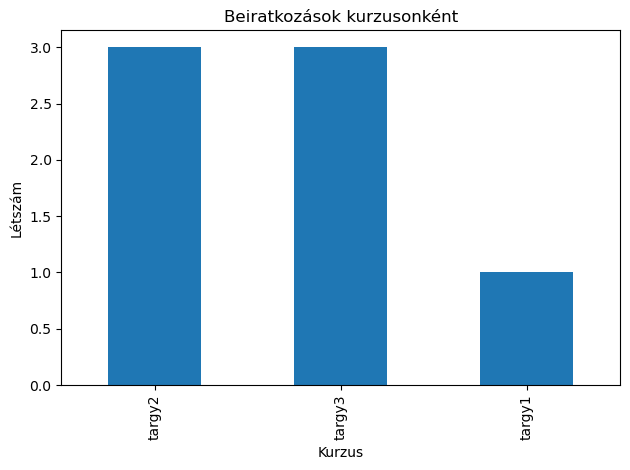

In [39]:
# Beiratkozások kurzusonként
counts = df.groupby('course_name').size().sort_values(ascending=False)

plt.figure()
counts.plot(kind='bar')
plt.title('Beiratkozások kurzusonként')
plt.xlabel('Kurzus')
plt.ylabel('Létszám')
plt.tight_layout()
plt.show()

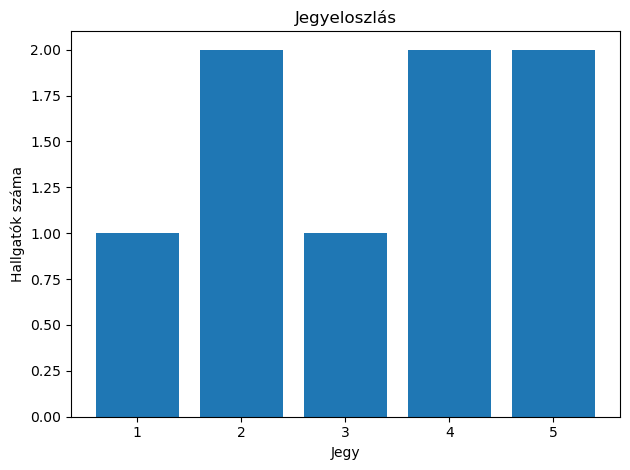

In [40]:
# Jegyeloszlás (csak meglévő jegyek)
grades = df['grade'].dropna()

plt.figure()
plt.hist(grades, bins=[1,2,3,4,5,6], align='left', rwidth=0.8)
plt.title('Jegyeloszlás')
plt.xlabel('Jegy')
plt.ylabel('Hallgatók száma')
plt.tight_layout()
plt.show()

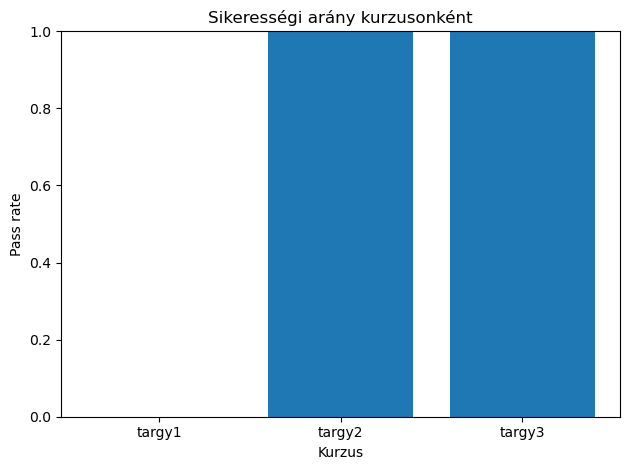

In [41]:
# Pass rate kurzusonként
plt.figure()
plt.bar(pass_rate['course_name'], pass_rate['pass_rate'])
plt.title('Sikerességi arány kurzusonként')
plt.xlabel('Kurzus')
plt.ylabel('Pass rate')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

## 7) Riport készítés és exportálás

In [43]:
# Példa riport: kockázatos hallgatók (alacsony átlag vagy hiányzó jegyek)
risk = df.copy()
risk['grade_zero_if_missing'] = risk['grade'].fillna(0)
summary = risk.groupby(['neptun','name'], as_index=False).agg(
    avg_grade=('grade_zero_if_missing','mean'),
    missing_counts=('missing_grade','sum'),
    earned_credits=('credits', lambda s: s[risk.loc[s.index, 'passed']].sum())
)

# Heurisztika: kockázatos, ha az átlag < 2.5 vagy van hiányzó jegy
summary['at_risk'] = (summary['avg_grade'] < 2.5) | (summary['missing_counts'] > 0)

display(summary.sort_values(['at_risk','avg_grade'], ascending=[False, True]))

# Exportálás Excel-be
report_path = 'mnt/data/neptun_report.xlsx'
with pd.ExcelWriter(report_path) as writer:
    avg_grade_by_course.to_excel(writer, sheet_name='avg_grade_by_course')
    credits_by_student.to_excel(writer, sheet_name='credits_by_student', index=False)
    pass_rate.to_excel(writer, sheet_name='pass_rate', index=False)
    summary.to_excel(writer, sheet_name='student_risk', index=False)

print('Report exported to:', report_path)

,neptun,name,avg_grade,missing_counts,earned_credits,at_risk
1,DEF456,Szabó Béla,2.333333,0,10.0,True
0,ABC123,Kovács Anna,3.666667,0,10.0,False
2,GHI789,Nagy Csilla,4.000000,0,10.0,False


Report exported to: mnt/data/neptun_report.xlsx


## 8) Képek kezelése – hallgatói fotók összerendelése Neptun-kód alapján

In [44]:
def load_student_photo(neptun):
    path = os.path.join(PHOTOS_DIR, f'{neptun}.png')
    if os.path.exists(path):
        return Image.open(path)
    else:
        return None

# Válasszunk ki pár hallgatót és jelenítsük meg a képeiket (ha megvan)
sample_neptuns = students['neptun'].tolist()

for code in sample_neptuns:
    img = load_student_photo(code)
    if img is None:
        print(code, '→ NINCS kép (placeholder szükséges)')
    else:
        print(code, '→ kép betöltve, méret:', img.size)
        display(img)

ABC123 → NINCS kép (placeholder szükséges)
DEF456 → NINCS kép (placeholder szükséges)
GHI789 → NINCS kép (placeholder szükséges)
JKL012 → NINCS kép (placeholder szükséges)
MNO345 → NINCS kép (placeholder szükséges)


### 8/a) Egyszerű képfeldolgozás: átméretezés és szürkeárnyalatos konverzió

In [45]:
# Átméretezés és szürkeárnyalatos mentés új fájlba
out_dir = '/mnt/data/photos_processed'
os.makedirs(out_dir, exist_ok=True)

for code in sample_neptuns:
    img = load_student_photo(code)
    if img is None:
        continue
    img_resized = img.resize((128,128))
    img_gray = img_resized.convert('L')
    img_gray.save(os.path.join(out_dir, f'{code}_gray.png'))

print('Processed images saved to:', out_dir)

Processed images saved to: /mnt/data/photos_processed


## 9) Gyakorló feladatok (önálló munka)

1. **Adattisztítás:** adj hozzá új hallgatót üres vagy hibás e-mail címmel, majd írj kódot a korrekciójára.  
2. **Hiányzó jegyek:** változtasd meg a pótlás logikáját (pl. mediánnal töltsd ki kurzusonként).  
3. **Pivot:** készíts pivot táblát, amely a kurzusok *átlagos kreditszámát* és *hallgatói létszámát* mutatja.  
4. **Riport:** állíts elő külön Excel-lapot, amely csak a „kockázatos” hallgatókat listázza indoklással.  
5. **Képek:** készíts helyettesítő (placeholder) képet azoknak, akiknél nincs fotó, és rendeld hozzájuk.  
6. **Vizualizáció:** rajzolj vonaldiagramot, ami a beiratkozások időbeli alakulását mutatja (ha több dátum áll rendelkezésre).

**Tipp:** Ha a saját Neptun-adatmintáddal dolgozol, csak cseréld ki a `DATA_XLSX` útvonalat, és igazítsd a kódot a saját oszlopneveidhez.
